In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F

# from torch.autograd import grad
from scipy.integrate import odeint, solve_ivp

# torch.manual_seed(1234)

## Data Generation

In [32]:
# A grid of time points (in days)
t_array = np.linspace(0, 200, 101) #from day 0 to day 500, generate 100 points

# Initial conditions (from the literature)
N = 10000099 #population size
S0 = N - 100 #everyone starts out as susceptible, except for 1 person that is infected
E0 = 100
A0 = 1
I0 = 1 # 1 infected person
Q0 = 1
R0 = 1
H0 = 1
D0 = 0

# Parameters (from the literature)
beta = 0.5 # 0.14
p = 0.6
sigma = 1 / 6
v = 0.8
omega = 1 / 14
xi = 0.5
gamma = 1 / 5
q = 0.19
alphaR = 1 / 2 
alphaD = 1 / 2
x_hat = 0.1
B = 2700

In [33]:
# The SIR model differential equations.
def deriv(
    y,
    t,
    N,
    beta,
    p,
    sigma,
    v,
    omega,
    xi,
    gamma,
    q,
    alphaR,
    alphaD,
    B,
    x_hat
):
    S, E, A, I, Q, R, H, D = y
    xt = death_ratio(x_hat, H, B)
    dSdt = - beta * S * (A + I) / N
    dEdt = beta * S * (A + I) / N - sigma * E
    dAdt = (1 - p) * sigma * E - omega * A
    dIdt = p * sigma * E + (1 - v) * omega * A - xi * S
    dQdt = xi * I - gamma * Q
    dRdt = v * omega * A + (1 - q) * gamma * Q + (1 - xt) * alphaR * H
    dHdt = q * gamma * Q - ((1 - xt) * alphaR + xt * alphaD) * H
    dDdt = xt * alphaD * H
    
    return [dSdt, dEdt, dAdt, dIdt, dQdt, dRdt, dHdt, dDdt]


def death_ratio(x_hat, H, B):
    return x_hat
    if H <= B:
        return x_hat
    else:
        return (x_hat * B + H - B) / H

In [34]:
# Initial conditions vector
y0 = [S0, E0, A0, I0, Q0, R0, H0, D0]
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t_array, args=(N, beta, p, sigma, v, omega, xi, gamma, q, alphaR, alphaD, B, x_hat ), full_output = 1)
# S, E, A, I, Q, R, H, D = ret[0].T

In [38]:
S, E, A, I, Q, R, H, D = ret[0].T

In [37]:
ret[0].shape

(101, 8)

### solve_ivp

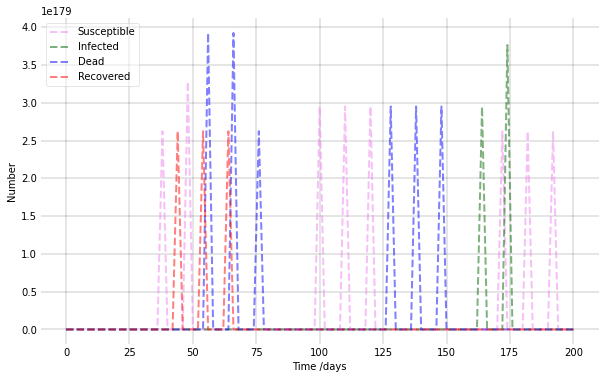

In [40]:
# Plot the data
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t_array, S, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='dashed')
ax.plot(t_array, I, 'darkgreen', alpha=0.5, lw=2, label='Infected', linestyle='dashed')
ax.plot(t_array, D, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t_array, R, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [27]:
class DINN(nn.Module):
    def __init__(
        self,
        t,
        S_data,
        E_data,
        A_data,
        I_data,
        Q_data,
        R_data,
        H_data,
        D_data,
    ):
        super(DINN, self).__init__()
        
        self.N = 59e6 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t), 1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.E = torch.tensor(E_data)
        self.A = torch.tensor(A_data)
        self.I = torch.tensor(I_data)
        self.Q = torch.tensor(Q_data)
        self.R = torch.tensor(R_data)
        self.H = torch.tensor(H_data)
        self.D = torch.tensor(D_data)
        
        
        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        # self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        # self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        # self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.p_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.xi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alphaR_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alphaD_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x_hat_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        # self.B_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)
        
        
        #find values for normalization
        self.S_max = max(self.S)
        self.E_max = max(self.E)
        self.A_max = max(self.A)
        self.I_max = max(self.I)
        self.Q_max = max(self.Q)
        self.R_max = max(self.R)
        self.H_max = max(self.H)
        self.D_max = max(self.D)

        self.S_min = min(self.S)
        self.E_min = min(self.E)
        self.A_min = min(self.A)
        self.I_min = min(self.I)
        self.Q_min = min(self.Q)
        self.R_min = min(self.R)
        self.H_min = min(self.H)
        self.D_min = min(self.D)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.A_hat = (self.A - self.A_min) / (self.A_max - self.A_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.Q_hat = (self.Q - self.Q_min) / (self.Q_max - self.Q_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
          

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 8)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 8)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 8)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 8)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 8)); self.m5[:, 0] = 1
        self.m6 = torch.zeros((len(self.t), 8)); self.m6[:, 1] = 1
        self.m7 = torch.zeros((len(self.t), 8)); self.m7[:, 2] = 1
        self.m8 = torch.zeros((len(self.t), 8)); self.m8[:, 3] = 1
        
        
        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(
            list(
                [
                    self.beta_tilda,
                    self.p_tilda,
                    self.sigma_tilda,
                    self.v_tilda,
                    self.omega_tilda,
                    self.xi_tilda,
                    self.gamma_tilda,
                    self.q_tilda,
                    self.alphaR_tilda,
                    self.alphaD_tilda,
                    self.x_hat_tilda,
                ]
            )
        )

    #force parameters to be in a range
    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)
    
    @property
    def p(self):
        return torch.tanh(self.p_tilda)
    
    @property
    def sigma(self):
        return torch.tanh(self.sigma_tilda)
    
    @property
    def v(self):
        return torch.tanh(self.v_tilda)
    
    @property
    def omega(self):
        return torch.tanh(self.omega_tilda)
    
    @property
    def xi(self):
        return torch.tanh(self.xi_tilda)
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)
    
    @property
    def q(self):
        return torch.tanh(self.q_tilda)
    
    @property
    def alphaR(self):
        return torch.tanh(self.alphaR_tilda)
    
    @property
    def alphaD(self):
        return torch.tanh(self.alphaD_tilda)
    
    @property
    def x_hat(self):
        return torch.tanh(self.x_hat_tilda)
    
    
    
#     @property
#     def alpha(self):
#         return torch.tanh(self.alpha_tilda) #* 0.1 + 0.2

#     @property
#     def beta(self):
#         return torch.tanh(self.beta_tilda) #* 0.01 + 0.05
    
#     @property
#     def gamma(self):
#         return torch.tanh(self.gamma_tilda) #* 0.01 + 0.03

    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 8) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
            
            #pass the timesteps batch to the neural network
            sidr_hat = self.net_sidr(t_batch)
            
            #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
            S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

            #S_t
            sidr_hat.backward(self.m1, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I_t
            sidr_hat.backward(self.m2, retain_graph=True)
            I_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #D_t
            sidr_hat.backward(self.m3, retain_graph=True)
            D_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            sidr_hat.backward(self.m4, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_() 

            #unnormalize
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            I = self.I_min + (self.I_max - self.I_min) * I_hat
            D = self.D_min + (self.D_max - self.D_min) * D_hat      
            R = self.R_min + (self.R_max - self.R_min) * R_hat        

            f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
            f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
            f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
            f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)        

            return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat

    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.I_hat - I_pred))+
                    torch.mean(torch.square(self.D_hat - D_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)
                print('alpha: (goal 0.191 ', self.alpha)
                print('beta: (goal 0.05 ', self.beta)
                print('gamma: (goal 0.0294 ', self.gamma)
                print('#################################')                

        return S_pred_list, I_pred_list, D_pred_list, R_pred_list